In [21]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import seaborn as sns
import pandas as pd
%pylab inline

from subprocess import check_output

Populating the interactive namespace from numpy and matplotlib


In [22]:
df = pd.read_csv('movie_metadata.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       4993 non-null float64
duration                     5028 non-null float64
director_facebook_likes      4939 non-null float64
actor_3_facebook_likes       5020 non-null float64
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5036 non-null float64
gross                        4159 non-null float64
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null int64
cast_total_facebook_likes    5043 non-null int64
actor_3_name                 5020 non-null object
facenumber_in_poster         5030 non-null float64
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-

In [23]:
first_actors = set(df.actor_1_name.unique())
second_actors = set(df.actor_2_name.unique())
third_actors = set(df.actor_3_name.unique())
print('Those only in first name', len(first_actors - second_actors - third_actors))
print('Those only in second name', len(second_actors - first_actors - third_actors))
print('Those only in third name', len(third_actors - first_actors - second_actors))

# Color
df.color = df.color.map({'Color': 1, 'Black and White': 0})
# Genre
unique_genre_label = set()
for genres in df.genres.str.split('|').values:
    unique_genre_label = unique_genre_label.union(set(genres))
for label in unique_genre_label:
    df['Genre='+label] = df.genres.str.contains(label).astype(int)
df = df.drop('genres', axis=1)

Those only in first name 865
Those only in second name 1469
Those only in third name 2126


In [24]:
if len(df.drop_duplicates(subset=['movie_title', 'title_year', 'movie_imdb_link'])) < len(df):
    print("Duplicates exist!")
    # Print the duplicates
    duplicates = df[df.movie_title.map(df.movie_title.value_counts() > 1)]
    duplicates.sort_values('movie_title')[['movie_title', 'title_year']]
    print(duplicates)
    df = df.drop_duplicates(subset=['movie_title', 'title_year', 'movie_imdb_link'])

Duplicates exist!
      color       director_name  num_critic_for_reviews  duration  \
6       1.0           Sam Raimi                   392.0     156.0   
17      1.0         Joss Whedon                   703.0     173.0   
25      1.0       Peter Jackson                   446.0     201.0   
30      1.0          Sam Mendes                   750.0     143.0   
33      1.0          Tim Burton                   451.0     108.0   
38      1.0           Sam Raimi                   525.0     130.0   
40      1.0     Joseph Kosinski                   469.0     125.0   
50      1.0        Baz Luhrmann                   490.0     143.0   
63      1.0         David Yates                   248.0     110.0   
79      1.0         Jon Favreau                   370.0     106.0   
84      1.0        Roland Joffé                    10.0     109.0   
98      1.0        Hideaki Anno                     1.0     120.0   
100     1.0           Rob Cohen                   187.0     106.0   
137     1.0     

In [25]:
counts = df.language.value_counts()
df.language = df.language.map(counts)
df.language

0       4584.0
1       4584.0
2       4584.0
3       4584.0
4          NaN
5       4584.0
6       4584.0
7       4584.0
8       4584.0
9       4584.0
10      4584.0
11      4584.0
12      4584.0
13      4584.0
14      4584.0
15      4584.0
16      4584.0
17      4584.0
18      4584.0
19      4584.0
20      4584.0
21      4584.0
22      4584.0
23      4584.0
24      4584.0
25      4584.0
26      4584.0
27      4584.0
28      4584.0
29      4584.0
         ...  
5013    4584.0
5014    4584.0
5015    4584.0
5016    4584.0
5017    4584.0
5018    4584.0
5019    4584.0
5020    4584.0
5021    4584.0
5022       1.0
5023    4584.0
5024    4584.0
5025    4584.0
5026      73.0
5027       4.0
5028    4584.0
5029      17.0
5030    4584.0
5031    4584.0
5032    4584.0
5033    4584.0
5034    4584.0
5035      40.0
5036    4584.0
5037    4584.0
5038    4584.0
5039    4584.0
5040    4584.0
5041    4584.0
5042    4584.0
Name: language, Length: 4919, dtype: float64

In [26]:
count = df.country.value_counts()
df.country = df.country.map(count)
#df.country
counts = df.content_rating.value_counts()
df.content_rating = df.content_rating.map(counts)
#df.content_rating
#df.plot_keywords.head()
unique_words = set()
for wordlist in df.plot_keywords.str.split('|').values:
    if wordlist is not np.nan:
        unique_words = unique_words.union(set(wordlist))
plot_wordbag = list(unique_words)
for word in plot_wordbag:
    df['plot_has_' + word.replace(' ', '-')] = df.plot_keywords.str.contains(word).astype(float)
df = df.drop('plot_keywords', axis=1)
# Is anything left to be done other than imputing?
print(df.select_dtypes(include=['O']).columns)
# We replace director name with counts of movies they've done
df.director_name = df.director_name.map(df.director_name.value_counts())
# We replace actor names with the number of movies they appear in.
counts = pd.concat([df.actor_1_name, df.actor_2_name, df.actor_3_name]).value_counts()
#counts.head()
df.actor_1_name = df.actor_1_name.map(counts)
df.actor_2_name = df.actor_2_name.map(counts)
df.actor_3_name = df.actor_3_name.map(counts)
# I have no clue what to do with the title. I'll keep it for now in order to search by name
df = df.drop(['movie_imdb_link'], axis=1)
# Let's check if anything is left as object
df.select_dtypes(include=['O']).columns

Index(['director_name', 'actor_2_name', 'actor_1_name', 'movie_title',
       'actor_3_name', 'movie_imdb_link'],
      dtype='object')


Index(['movie_title'], dtype='object')

In [27]:
df.shape

(4919, 8136)

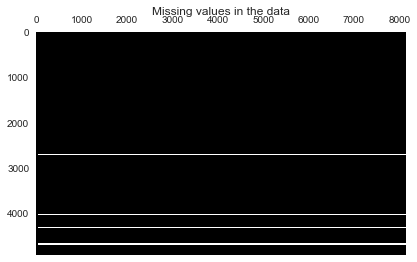

In [28]:
# hold your horses, we still need to fill those missing values.
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)
plt.matshow(~df.isnull())
plt.title('Missing values in the data')

(4767, 8136) (4919, 8136)


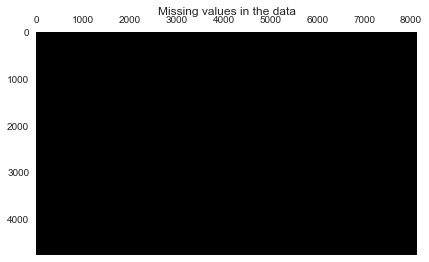

In [29]:
nullcount = df.isnull().sum(axis=1)
ndf = df.dropna(thresh=100)
print(ndf.shape, df.shape)
# Let's see those nulls again
plt.matshow(~ndf.isnull())
plt.title('Missing values in the data')

In [30]:
# We'll treat fillna as a regression / classification problem here.
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def reg_class_fill(df, column, classifier):
    """Treat missing values as a classification / regresion problem"""
    ndf = df.dropna(subset=[col for col in df.columns if col != column])
    nullmask = ndf[column].isnull()
    train, test  = ndf[~nullmask], ndf[nullmask]
    train_x, train_y = train.drop(column, axis=1), train[column]
    classifier.fit(train_x, train_y)
    if len(test) > 0:
        test_x, test_y = test.drop(column, axis=1), test[column]
        values = classifier.predict(test_x)
        test_y = values
        new_x, new_y = pd.concat([train_x, test_x]), pd.concat([train_y, test_y])
        newdf = new_x[column] = new_y
        return newdf
    else:
        return ndf

In [31]:
r, c = KNeighborsRegressor, KNeighborsClassifier  # Regress or classify
title_encoder = LabelEncoder()
title_encoder.fit(ndf.movie_title)
ndf.movie_title = title_encoder.transform(ndf.movie_title)

In [32]:
print(ndf[ndf.columns[:25]].isnull().sum())

color                        214
director_name                 93
num_critic_for_reviews        26
duration                       8
director_facebook_likes       93
actor_3_facebook_likes        17
actor_2_name                  10
actor_1_facebook_likes         7
gross                        751
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  17
facenumber_in_poster          11
num_user_for_reviews           7
language                       8
country                        3
content_rating               223
budget                       445
title_year                    93
actor_2_facebook_likes        10
imdb_score                     0
aspect_ratio                 244
movie_facebook_likes           0
dtype: int64


In [33]:
# Since our imputation will impact other imputations, we specify an order
# Typically we should do this independently and then combine the results, but meh for now
impute_order = [('director_name', c), ('title_year', c),
                ('actor_1_name', c), ('actor_2_name', c), ('actor_3_name', c),
                ('gross', r), ('budget', r), ('aspect_ratio', r),
                ('content_rating', r), ('num_critic_for_reviews', r)]
for col, classifier in impute_order:
    ndf = reg_class_fill(ndf, col, classifier())
    print(col, 'Done')

director_name Done
title_year Done
actor_1_name Done
actor_2_name Done
actor_3_name Done
gross Done
budget Done
aspect_ratio Done
content_rating Done
num_critic_for_reviews Done


In [34]:
# Again we check for what else needs to be imputed.
ndf[ndf.columns[:25]].isnull().sum()

color                        0
director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
aspect_ratio                 0
movie_facebook_likes         0
dtype: int64

In [35]:
ndf.isnull().sum().sum()

0

In [36]:
titles = title_encoder.inverse_transform(ndf.movie_title)

In [37]:
titles

array(['Avatar\xa0', "Pirates of the Caribbean: At World's End\xa0",
       'Spectre\xa0', ..., 'Primer\xa0', 'El Mariachi\xa0',
       'My Date with Drew\xa0'], dtype=object)

In [38]:
# Give us 5 movies that you liked
def get_movies(names):
    movies = []
    for name in names:
        found = [i for i in titles if name.lower() in i.lower()]
        if len(found) > 0:
            movies.append(found[0])
            print(name, ': ', found, 'added', movies[-1], 'to movies')
        else:
            print(name, ': ', found)
    print('-'*10)
    print(movies)
    moviecodes = title_encoder.transform(movies)
    return moviecodes, movies
names = ['fight club', 'gump', # This one is Forrest Gump
                 'usual suspects', 'silence of the lambs']
moviecodes, movies = get_movies(names)

fight club :  ['Fight Club\xa0'] added Fight Club  to movies
gump :  []
usual suspects :  ['The Usual Suspects\xa0'] added The Usual Suspects  to movies
silence of the lambs :  ['The Silence of the Lambs\xa0'] added The Silence of the Lambs  to movies
----------
['Fight Club\xa0', 'The Usual Suspects\xa0', 'The Silence of the Lambs\xa0']


In [39]:
data = ndf.drop('movie_title', axis=1)
data = MinMaxScaler().fit_transform(data)

In [40]:
movies

['Fight Club\xa0', 'The Usual Suspects\xa0', 'The Silence of the Lambs\xa0']

In [41]:
titles

array(['Avatar\xa0', "Pirates of the Caribbean: At World's End\xa0",
       'Spectre\xa0', ..., 'Primer\xa0', 'El Mariachi\xa0',
       'My Date with Drew\xa0'], dtype=object)

In [43]:
# We assume KNN's assumptions as valid and proceede to compute a distance_matrix
from sklearn.neighbors import KDTree
from collections import Counter

In [44]:
tree = KDTree(data, leaf_size=2)

In [45]:
def recommend(movies, tree, titles, data):
    """
    It is assumed that the movies are in order of decreasing like-able-ness
    Recommend movies on the basis of the KDTree generated.
    Return them in order of increasing distance form knowns.
    """
    titles = list(titles)
    length, recommendations = len(movies) + 1,[]
    
    for i, movie in enumerate(movies):
        weight = length - i
        dist, index = tree.query([data[titles.index(movie)]], k=3)
        for d, m in zip(dist[0], index[0]):
            recommendations.append((d*weight, titles[m]))
    recommendations.sort()
    # Stuff is reorganized by frequency.
    rec = [i[1].strip() for i in recommendations if i[1] not in movies]
    rec = [i[1] for i in sorted([(v, k) for k, v in Counter(rec).items()],
                                reverse=True)]
    return rec

In [46]:
rec = recommend(movies, tree, titles, data)

print('Rank | Movie')
print('-----|------')
fmt = '{}.   | {}'
for index, movie in enumerate(rec[:9]):
    print(fmt.format(index + 1, movie))

Rank | Movie
-----|------
1.   | Untraceable
2.   | The Young Messiah
3.   | Suspect Zero
4.   | Blood Ties
5.   | Black or White
6.   | 15 Minutes


In [48]:
names = ['spectre', 'mission'] # dedicated to A.S.
moviecodes, movies = get_movies(names)
rec = recommend(movies, tree, titles, data)
print('-'*50)
print('Recommending on the basis of the above movies')
print('-'*50)
print()
print('+-----|------')
print('|Rank | Movie')
print('+-----|------')
fmt = '|{}.   | {}'
for index, movie in enumerate(rec[:9]):
    print(fmt.format(index + 1, movie))
print('+-----|------')

spectre :  ['Spectre\xa0'] added Spectre  to movies
mission :  ['Mission: Impossible - Rogue Nation\xa0', 'Mission: Impossible III\xa0', 'Mission: Impossible - Ghost Protocol\xa0', 'Mission: Impossible II\xa0', 'Mission to Mars\xa0', 'Mission: Impossible\xa0', 'Admission\xa0', 'Police Academy: Mission to Moscow\xa0'] added Mission: Impossible - Rogue Nation  to movies
----------
['Spectre\xa0', 'Mission: Impossible - Rogue Nation\xa0']
--------------------------------------------------
Recommending on the basis of the above movies
--------------------------------------------------

+-----|------
|Rank | Movie
+-----|------
|1.   | The World Is Not Enough
|2.   | Mission: Impossible
|3.   | From Paris with Love
|4.   | For Your Eyes Only
+-----|------
